In [1]:
#!pip install pyvinecopulib
#!pip install scikit-gstat
#!pip install pykrige
#!pip install openturns


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import skgstat as skg # for importing the meuse dataset

from functions.spvinecopulib import DataSet, SpatialCopula, SpatialVineCoupla                                                 

In [3]:
# load in data (same as in spcopula demo)

# options for variables: zinc, copper, lead, and cadmium
variable = 'zinc'

src = skg.data.meuse(variable=variable)

coords, vals = src.get('sample')

# make a dataframe
df = pd.DataFrame(
    {'x': coords[:, 0], 'y': coords[:, 1], variable: vals.flatten()})

df.head()


,x,y,zinc
0,181072,333611,1022
1,181025,333558,1141
2,181165,333537,640
3,181298,333484,257
4,181307,333330,269


In [4]:
# read the data from the SIC2004 csv file
# df = pd.read_csv('sic2004data_01\sic2004_01.csv', names=['x', 'y', 'radiation'])
# variable = 'radiation'

# df_test = pd.read_csv('sic2004data_01\\1st_file_true_values.csv',
#                       names=['x', 'y', 'radiation'])
# variable = 'radiation'

# df.head()


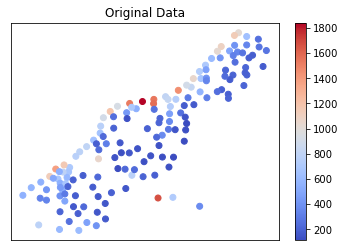

In [5]:
# create a scatter plot of the zinc value in the coordinatess
plt.scatter(df["x"], df["y"], c=df[variable], cmap=plt.cm.coolwarm)
# get current axes
ax = plt.gca()

plt.xlabel("x")
plt.ylabel("y")
plt.title("Original Data")
# hide x-axis
ax.get_xaxis().set_visible(False)

# hide y-axis
ax.get_yaxis().set_visible(False)

plt.colorbar()
plt.show()


Text(0, 0.5, 'number of samples')

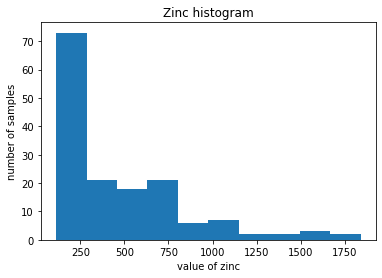

In [6]:
# plot the zinc values in a histogram
plt.hist(df[variable], bins=10)
plt.title("Zinc histogram")
plt.xlabel("value of zinc")
plt.ylabel("number of samples")


In [7]:
# initialize the DataSet class with df and variable
dataset = DataSet(df, variable_of_interest=variable)

In [8]:
# fit a kriging model and calculate results
dataset.calculate_kriging()

MAE: 376.7622060353798
Bias:  0.0
RMSE:  517.443436331247


In [9]:
# add the rank column to the original dataframe
dataset.add_rank()
dataset.df

,x,y,zinc,rank
0,181072,333611,1022,0.897436
1,181025,333558,1141,0.935897
2,181165,333537,640,0.724359
3,181298,333484,257,0.423077
4,181307,333330,269,0.448718
...,...,...,...,...
150,179184,330182,166,0.144231
151,179085,330292,496,0.628205
152,178875,330311,342,0.512821
153,179466,330381,162,0.134615


In [10]:
# construct the pairs for the whole dataset (without the cutoff value)
dataset.construct_pairs()

# cutoff value for the distance matrix
cutoff_value = 800

# convert the dataframe in pairs of stations (using the cutoff value)
dataset.apply_cutoff(cutoff_value)

#prints first 5 rows of the pairs of stations dataframe
dataset.all_pairs.head()


23870it [00:01, 16860.70it/s]


,index1,index2,rank1,rank2,distance
0,0,1,0.897436,0.935897,70.837843
1,0,2,0.897436,0.724359,118.848643
2,0,3,0.897436,0.423077,259.239272
3,0,4,0.897436,0.448718,366.314073
4,0,5,0.897436,0.461538,473.629602


In [11]:
# build the neighbourhoods (sorted by distance) and store them in a list
neigh_size = 10
dataset.build_neighbourhoods(neigh_size)

100%|██████████| 155/155 [00:00<00:00, 858.92it/s]


In [12]:
# calculate bins for the pairs of stations
num_bins = 10

# initiate the spatial copula with dataset, number of bins and cutoff value
spatial_copula = SpatialCopula(dataset, dataset.neighbourhoods, num_bins, cutoff_value)

# calculate the bins
spatial_copula.calculate_bins()

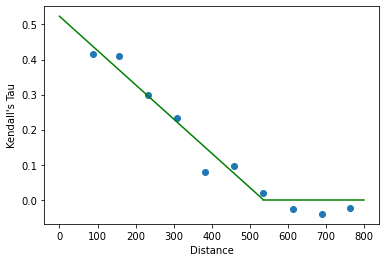

In [13]:
# calculate kendalls tau per bin
spatial_copula.calculate_kendall()

# fit the model for kendall's tau and bins
spatial_copula.fit_model_kendall()

# plot the model
spatial_copula.plot_kendall()

In [14]:
# convert the bins to copulas
spatial_copula.calculate_copulas()

print(spatial_copula.copulas)

[<pyvinecopulib.Bicop>
Gumbel, parameters = 1.77618, <pyvinecopulib.Bicop>
Gumbel 180°, parameters = 1.586, <pyvinecopulib.Bicop>
Gumbel 180°, parameters = 1.41818, <pyvinecopulib.Bicop>
Gumbel 180°, parameters = 1.28571, <pyvinecopulib.Bicop>
Joe 180°, parameters = 1.30871, <pyvinecopulib.Bicop>
Gaussian, parameters = 0.118137, <pyvinecopulib.Bicop>
Independence, <pyvinecopulib.Bicop>
Independence]


In [15]:
# now we need to predict the mean with the expectation
# with the list_neighbourhood_ln as neighs
# df as our data train
# df as our data test
# super_cops for the copulas

dataset.construct_pairs_lognorm()

# here we choose the number of neighbours we want for prediction
dataset.build_neighbourhoods_ln(neighbourhood_size=neigh_size)

23870it [00:01, 16009.66it/s]
100%|██████████| 155/155 [00:00<00:00, 1110.27it/s]


In [16]:
# create the list of number of bins and cutoffs for each spatial copula
# when num_bins=1, the copula is static (non-spatially varying)
num_bins_list = [spatial_copula.num_bins] + [10]*20 + [6]*1 + [1]*10
cutoff_list = [spatial_copula.cutoff_value] + [800]*20 + [600]*1 + [400]*10

In [17]:
# number of copulas ususally equal neighbourhood size
# can be changed into a number lower than neighbourhood size
num_copulas = neigh_size

spatial_vine_copula = SpatialVineCoupla(
    first_spatial_copula=spatial_copula, dataset=dataset,
    num_copulas=num_copulas, num_bins_list=num_bins_list, cutoff_list=cutoff_list)


100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


In [18]:
# calculate the predictions with the spatial vine copula
spatial_vine_copula.calculate_predictions()
spatial_vine_copula.get_results()

100%|██████████| 155/155 [00:05<00:00, 26.95it/s]

Number of errors: 0
Median Absolute Error: 95.42659587014103
Mean Absolute Error: 145.86150915337427
Bias: 28.00835661451847
Root Mean Squared Error: 230.35725144608222


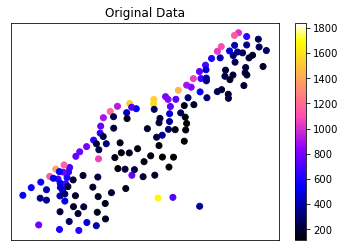

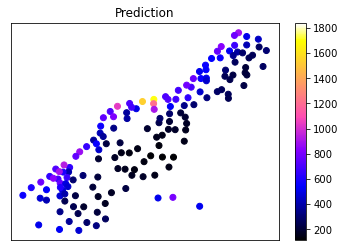

In [19]:
# plot the original and predicted data
spatial_vine_copula.plot_original_data()
spatial_vine_copula.plot_predicted_data()

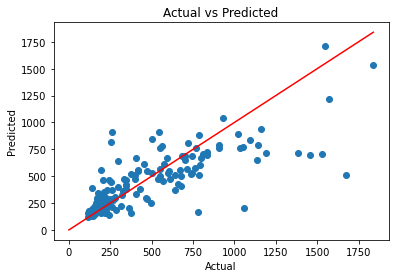

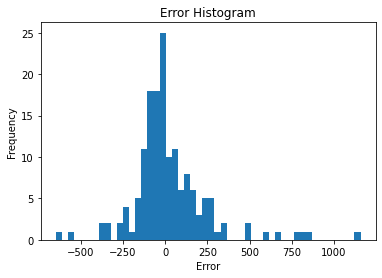

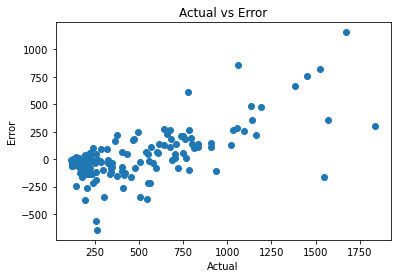

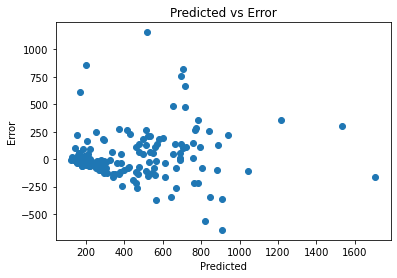

Median Absolute Error: 95.42659587014103
Mean Absolute Error: 145.86150915337427
Mean Squared Error: 53064.463293793546
Root Mean Squared Error: 230.35725144608222


In [20]:
# some additional plots and statistics
spatial_vine_copula.plot_result_statistics()